In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bnk import *

# Structure

## Cavity Structure

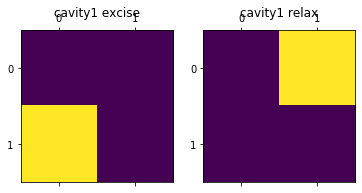

In [2]:
class Cavity:
    def __init__(self, n=4, name='cavity'):
        space = Space(n, name)
        
        excise = 0
        for i in range(1, n):
            excise_i = space.eigenstate(i) @ space.eigenstate(i - 1).ct
            excise += np.sqrt(i) * excise_i
        relax = excise.ct

        self.space = space
        self.excise = excise
        self.relax = relax
    
    def eigenstate(self, k):
        return self.space.eigenstate(k)

cavity1 = Cavity(2,'cavity1')
cavity2 = Cavity(2,'cavity2')
cavity3 = Cavity(2,'cavity3')


plt.subplot(1, 2, 1)
plt.matshow(cavity1.excise.flattened_values, 0)
plt.title("cavity1 excise")

plt.subplot(1, 2, 2)
plt.matshow(cavity1.relax.flattened_values, 0)
plt.title("cavity1 relax")

plt.show()

## Sink Structure

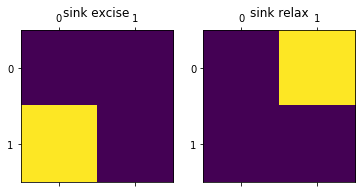

In [3]:
sink_space = Space(2,'sink')

sink_excise = sink_space.eigenstate(1) @ sink_space.eigenstate(0).ct
sink_relax = sink_excise.ct


plt.subplot(1, 2, 1)
plt.matshow(sink_excise.flattened_values, 0)
plt.title("sink excise")

plt.subplot(1, 2, 2)
plt.matshow(sink_relax.flattened_values, 0)
plt.title("sink relax")

plt.show()

# Evolution

## Hamiltonian

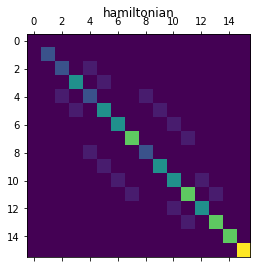

In [4]:
energy = (0
    + cavity1.excise @ cavity1.relax  
    + cavity2.excise @ cavity2.relax  
    + cavity3.excise @ cavity3.relax  
    + sink_excise @ sink_relax
)

interaction12 = ( 0
    + cavity1.relax @ cavity2.excise
    + cavity1.excise @ cavity2.relax
)

interaction23 = ( 0
    + cavity2.relax @ cavity3.excise
    + cavity2.excise @ cavity3.relax
)

def hamiltonian(hb, w, v12, v23):
    return hb * w * energy+ v12 * interaction12 + v23 * interaction23


plt.matshow(hamiltonian(1, 1, 0.3, 0.3).flattened_values)
plt.title("hamiltonian")
plt.show()

## Evolution

In [5]:
deco = sink_excise @ cavity2.relax

def evolve(rho, hb, w, v12, v23, gamma):
    hmt = hamiltonian(hb,w,v12,v23)
    deco_ct = deco.ct
    deco_ct_deco = deco_ct @ deco
    return hmt @ rho - rho @ hmt + 1j * gamma*(deco @ rho @ deco_ct - 0.5 * (deco_ct_deco@ rho + rho @ deco_ct_deco))

# Iteration

## Initial $\rho$

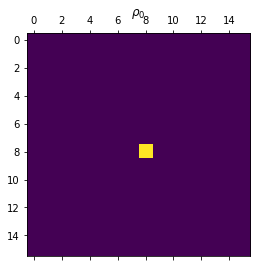

In [6]:
initial_state = \
    cavity1.eigenstate(1) @ \
    cavity2.eigenstate(0) @ \
    cavity3.eigenstate(0) @ \
    sink_space.eigenstate(0)

initial_rho = initial_state @ initial_state.ct


plt.matshow(initial_rho.flattened_values)
plt.title("$\\rho_0$")
plt.show()

## Constant

In [7]:
hb = 1
w = 1

v12 = 0.2
v23 = 0.2
gamma = 0.2

## Configurations

In [8]:
dt = 0.005
mt = 70

logs_dt = mt / 200

## Iterations

In [9]:
%%time

t = 0.0
rho = initial_rho

logs_t = float('-inf')
logs = []

while t < mt:
    t += dt
    rho += evolve(rho,hb,w,v12,v23,gamma) * (dt / (1j * hb))
    
    if t - logs_t > logs_dt:
        
        rho /= rho.trace().values
        
        logs_t = t
        
        prob_cavity1 = (cavity1.eigenstate(1).ct @ rho @ cavity1.eigenstate(1)).trace()
        prob_cavity2 = (cavity2.eigenstate(1).ct @ rho @ cavity2.eigenstate(1)).trace()
        prob_cavity3 = (cavity3.eigenstate(1).ct @ rho @ cavity3.eigenstate(1)).trace()
        prob_sink = (sink_space.eigenstate(1).ct @ rho @ sink_space.eigenstate(1)).trace()
        
        logs.append((t, prob_cavity1, prob_cavity2, prob_cavity3, prob_sink))
        
        print(f"\rcomputing...{t/mt:.2%}", end='')
        
print("\nfinished")

computing...99.59%
finished
Wall time: 56.4 s


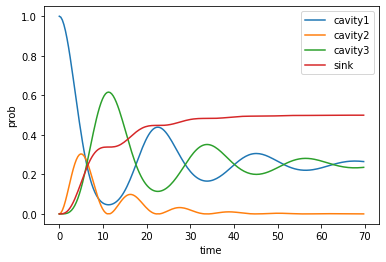

In [10]:
logs_t, logs_cavity1, logs_cavity2, logs_cavity3, logs_sink = np.transpose(logs)
plt.plot(logs_t, logs_cavity1, label='cavity1')
plt.plot(logs_t, logs_cavity2, label='cavity2')
plt.plot(logs_t, logs_cavity3, label='cavity3')
plt.plot(logs_t, logs_sink, label='sink')
plt.legend()
plt.xlabel("time")
plt.ylabel("prob")
plt.show()